In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np


# HED Model


# Check traditional edge detectors first. e.g., canny, sobel, roberts, etc.

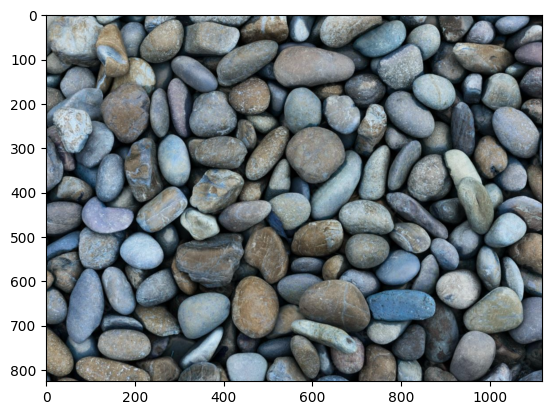

In [4]:
# load the input image and grab its dimensions, for future use while defining the blob
img = cv2.imread("pebbles.jpg")
plt.imshow(img);

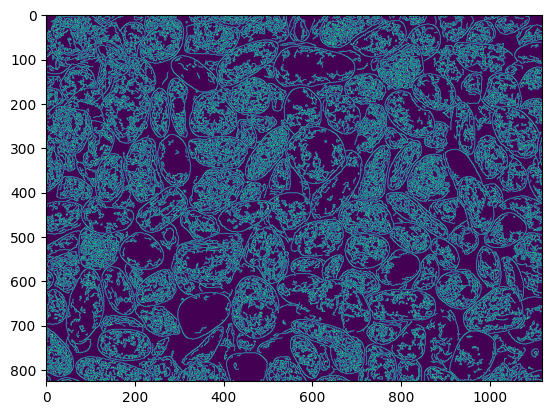

In [5]:
#Canny
canny_edge = cv2.Canny(img,50,150)
plt.imshow(canny_edge);


# Autocanny

In [6]:
#Autocanny
sigma = 0.3
median = np.median(img)

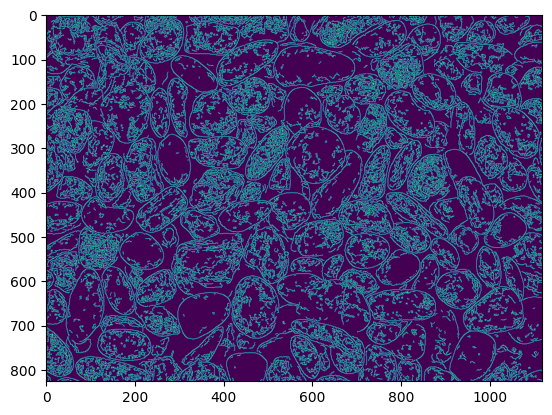

In [7]:

# apply automatic Canny edge detection using the computed median
lower = int(max(0, (1.0 - sigma) * median))
upper = int(min(255, (1.0 + sigma) * median))
auto_canny = cv2.Canny(img, lower, upper)
plt.imshow(auto_canny);




```
Steps for edge detection using HED:
    
1. Define the network and load the pre-trained model.​
2. Create blob from the image – basically create a preprocessed image​
3. Load pretrained model (you need both the proto text and caffe model files)​
4. Pass the blob image through model​ (forward pass)
5. Get output​


```

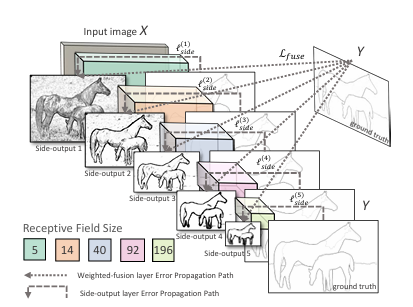

Model link :
https://github.com/abou-zithar/Object-segmentation-using-Deep-Learning-based-edge-detection-HED-

Shorter link :http://surl.li/vnotsm

Papper link :https://arxiv.org/pdf/1504.06375v2

# The pre-trained model that OpenCV uses has been trained in Caffe framework


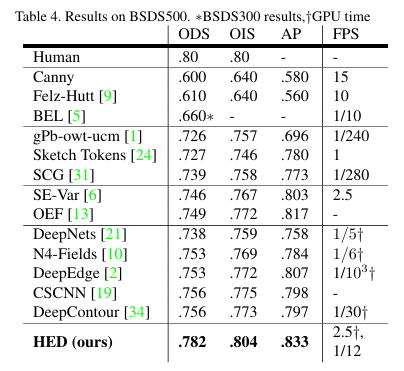

## Load the pre-trained Caffe model
- This framework is built on top of publicly available implementations of FCN and DSN and is implemented using the publicly available Caffe Library. From an initialization using the pre-trained VGG-16 Net model, the entire network in our HED system is fine-tuned.
This Caffe model is encoded into two files
- A prototxt file: A text Caffe JSON file that includes the model definition (deploy) (i.e. layers, expected input, …..)
- The pre-trained Caffe model: Neural Network weights.

In [8]:
#Download from the link above
protoPath = "deploy.prototxt"
modelPath = "hed_pretrained_bsds.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

In [ ]:
# There is a Crop layer that the HED network uses which is not implemented by 
# default so we need to provide our own implementation of this layer.
#Without the crop layer, the final result will be shifted to the right and bottom
#cropping part of the image
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]

In [ ]:
# register our crop layer with the model
cv2.dnn_registerLayer("Crop", CropLayer)

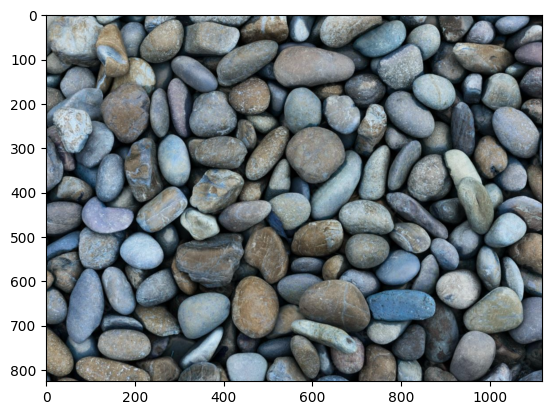

In [9]:
# load the input image and grab its dimensions, for future use while defining the blob
img = cv2.imread("pebbles.jpg")
plt.imshow(img);
(H, W) = img.shape[:2]

In [10]:
# construct a blob out of the input image 
#blob is basically preprocessed image. 
mean_pixel_values= np.average(img, axis = (0,1))
blob = cv2.dnn.blobFromImage(img, scalefactor=0.7, size=(W, H),
                             mean=(mean_pixel_values[0], mean_pixel_values[1], mean_pixel_values[2]),
                            #  mean=(105, 117, 123),
                             swapRB= False, crop=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-79.30174..99.19826].


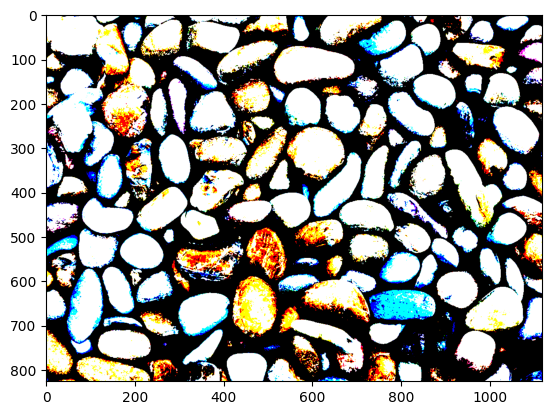

In [11]:

#OpenCV’s new deep neural network (dnn ) module contains two functions that 
#can be used for preprocessing images and preparing them for 
#classification via pre-trained deep learning models.
# It includes scaling and mean subtraction
#How to calculate the mean?

#View image after preprocessing (blob)
blob_for_plot = np.moveaxis(blob[0,:,:,:], 0,2)
plt.imshow(blob_for_plot);

In [23]:
# set the blob as the input to the network and perform a forward pass
# to compute the edges
net.setInput(blob)
hed = net.forward()

In [24]:
hed.shape

(1, 1, 826, 1119)

In [25]:
hed = hed[0,0,:,:]  #Drop the other axes 

In [26]:
hed.shape

(826, 1119)

In [27]:
hed.max()

0.9594685

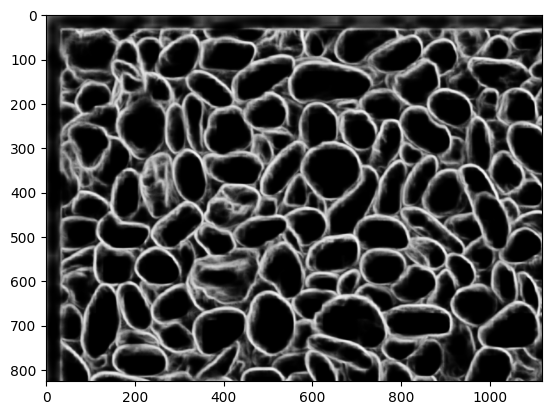

In [28]:


#hed = cv2.resize(hed[0, 0], (W, H))
hed = (255 * hed).astype("uint8")  #rescale to 0-255

plt.imshow(hed, cmap='gray');


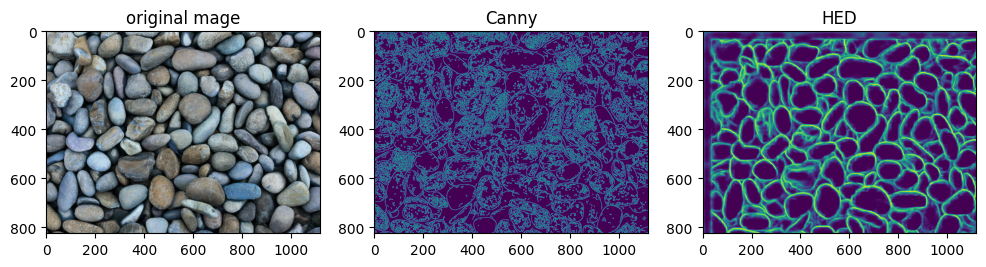

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title("original mage")
plt.imshow(img)
plt.subplot(132)
plt.title("Canny")
plt.imshow(auto_canny)
plt.subplot(133)
plt.title("HED")
plt.imshow(hed);



### HED Implementation in TensorFlow

Holistically-Nested Edge Detection (HED) is a deep learning approach designed for detecting edges in images. It uses a deep network that extracts features from multiple layers to capture edge information at different levels of abstraction.

#### HED Model Architecture in TensorFlow

The HED model is similar to the VGG-16 architecture but with additional side-output layers that provide edge maps at different scales. Here is a TensorFlow implementation of the HED architecture:

In [ ]:
def hed_model(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    side1 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    # Block 2
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    side2 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    # Block 3
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    side3 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    # Block 4
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    side4 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    # Block 5
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    side5 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    # Fuse side outputs
    fused = tf.keras.layers.Add()([side1, side2, side3, side4, side5])
    fused = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(fused)

    model = tf.keras.Model(inputs=inputs, outputs=[side1, side2, side3, side4, side5, fused])
    return model

# Instantiate the model
hed = hed_model()
hed.summary()


This model outputs edge maps at multiple stages of the network and then fuses them to produce the final edge map.

#### Loss Function for HED
HED uses a weighted cross-entropy loss that emphasizes edge pixels more than non-edge pixels. Here's the implementation:


In [ ]:
def hed_loss(y_true, y_pred):
    edge_weight = 1.5
    non_edge_weight = 1.0
    weights = tf.where(tf.equal(y_true, 1), edge_weight, non_edge_weight)
    return tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, labels=y_true, pos_weight=weights))

# Compile the model with the custom loss
hed.compile(optimizer='adam', loss=hed_loss, metrics=['accuracy'])

With this architecture and loss function, the HED model can be trained on edge detection datasets.
